<a href="https://colab.research.google.com/github/MeidanGR/SpeechEmotionRecognition_Realtime/blob/main/3_realtime_ser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Speech Emotion Recognition (Classification) in real-time using Deep LSTM layers**
### ***Real-time implementaion of the SER model***
---

### Final project (B.Sc. requirement)  
Development by **Meidan Greenberg & Linoy Hadad.**

Instructor: **Dr. Dima Alberg**

Industial Engineering and Management dept.

SCE Collage, Israel.


# **ABSTRACT**
This implementation of the pre-developed speech emotion recognition (SER) model is intended to analyze a speech audio input in real-time, identify and present the expressed emotion within it.


Classifying emotion from speech is a long-term problem rather than a short-term one. In Linguistics, two same phrases of speech can receive a different meaning just by emphasizing a word or even a syllable.

The model, an 87.23% accuracy LSTM based deep learning network, had learned how to classify the correct emotion expressed in a long-time sequence of speech features extracted from the audio signal.

This system will record audio input, create a temporary .wav file containing the audio signals recorded, preprocess it, and present the distribution of emotions found in speech. The sequence length chosen for the task is 7.1 seconds.
The process is cyclic and continues to accrue as long as there is continuous speech. After a silence of 2 seconds or more at the end of a sentence, the process will cease. At the end of a session, a summary is presented, holding the mean values of all emotions recognized during the session.

# **LIBRARIES & GOOGLE AUTH**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install pyaudio
!pip install json-tricks

In [3]:
%%capture
import os
from json_tricks import load

import numpy as np

import librosa
from pydub import AudioSegment, effects
import noisereduce as nr

import tensorflow as tf
import keras
from keras.models import model_from_json
from keras.models import load_model

import matplotlib.pyplot as plt

# **LOAD MODEL**
Loading the speech emotion recognition LSTM model and weights.

In [5]:
saved_model_path = '/content/drive/MyDrive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/MyDrive/Colab Notebooks/model8723.weights.h5'

#Reading the model from JSON file
with open(saved_model_path, 'r') as json_file:
    json_savedModel = json_file.read()

# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy',
                optimizer='RMSProp',
                metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 15, 64)              │          44,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,832 (304.03 KB)

 Trainable params: 77,832 (304.03 KB)

 Non-trainable params: 0 (0.00 B)

None


# **DATA PREPROCESSING**

An audio input .wav file is processed similarly to the model's preprocess in the following order:


*   Sample rate: number of audio samples per second is extracted by `librosa`.
*   'AudioSegment' instance: The audio is loaded to an object by the `AudioSegment` module of `pydub`.
*   Normalization: The 'AudioSegment' object is normalized to + 5.0 dBFS, by `effects` module of `pydub`.
*   Transforming the object to an array of samples by `numpy` & `AudioSegment`.
*   Noise reduction is being performed by `noisereduce`.

Speech features are extracted as well:
1.   Energy - Root Mean Square (RMS)
2.   Zero Crossed Rate (ZCR)
3.   Mel-Frequency Cepstral Coefficients (MFCCs)

With `frame_length = 2048`, `hop_lentgh = 512`, assuring equally sequential length.

The features are concatenated to an '`X`' variable, adjusted to fit the expected shape of the model: (batch, timesteps, feature). The function returns '`X_3D`' variable.

In [40]:
import librosa
import numpy as np
from pydub import AudioSegment, effects
import noisereduce as nr

def preprocess(file_path, frame_length=2048, hop_length=512, expected_features=108):
    '''
    A process to an audio .wav file before executing a prediction.

    Arguments:
      - file_path: The system path to the audio file.
      - frame_length: Length of the frame over which to compute the speech features (default: 2048).
      - hop_length: Number of samples to advance for each frame (default: 512).
      - expected_features: The number of features expected by the LSTM model (default: 108).

    Returns:
      'X_3D' variable, shaped as (batch, timesteps, feature) for a single file (batch = 1).
    '''
    # Fetch sample rate and waveform
    y, sr = librosa.load(file_path, sr=None)

    # Load audio file
    rawsound = AudioSegment.from_file(file_path, duration=None)

    # Normalize to 5 dBFS
    normalizedsound = effects.normalize(rawsound, headroom=5.0)

    # Transform the audio file to np.array of samples
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype='float32')

    # Noise reduction with adjusted settings
    final_x = nr.reduce_noise(y=normal_x, sr=sr, prop_decrease=0.9)

    # Extract features
    f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length).T
    f2 = librosa.feature.zero_crossing_rate(y=final_x, frame_length=frame_length, hop_length=hop_length).T
    f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=expected_features - f1.shape[1] - f2.shape[1], hop_length=hop_length).T

    # Concatenate features
    X = np.concatenate((f1, f2, f3), axis=1)

    # Ensure the number of features is correct
    if X.shape[1] != expected_features:
        print(f"Feature mismatch! Expected {expected_features}, got {X.shape[1]}")
        # Pad or truncate
        if X.shape[1] < expected_features:
            pad_width = expected_features - X.shape[1]
            X = np.pad(X, ((0, 0), (0, pad_width)), mode='constant')
        else:
            X = X[:, :expected_features]

    # Expand dimensions to match model input shape
    X_3D = np.expand_dims(X, axis=0)

    return X_3D


# **ADDITIONAL SETUP**
- An **emotion list** is defined to translate the model prediction output to a readable form.

- `is_silent` function is executed as a boolean state if silence of sequential audio was found. `is_silent` returns `True` when the maximum signal within the sequence is less than the threshold value defined.

In [50]:
emotions = {
    0: 'neutral',
    1: 'happy',
    2: 'sad',
    3: 'angry',
    4: 'fearful',
    5: 'disgusted',
    6: 'surprised',
    7: 'calm'
}
emo_list = list(emotions.values())  # ✅ Keeps order intact


# **REAL-TIME IMPLEMENTATION**

This implementation of an LSTM Speech Emotion Recognition model carries out a real-time emotion prediction of an audio input, recorded from the soundcard of the platform.
The process includes the following:


1.   Session start, opening a connection with the input channel by `pyaudio`.
2.   If **not silent**, the input signals will be recorded to a .wav file, by `pyaudio` and `wave`.

    2.1  After 7.1 seconds, the recording will stumble in order to send the last .wav file to the rest of the process before start recording a new one.

    2.2  The .wav file is preprocessed, in `preprocess` function.

    2.3  `model.predict` is executed, an array of 8 emotion probabilities is returned. E.g. `predictions = [array([p_neutral, p_calm, p_happy, p_sad, p_angry, p_feaful, p_disgust, p_suprised], dtype=float32)]`

    2.4   `predictions` are transformed to a compact representation (without 'array' and 'dtype' statements) and saved in a list.

    2.5 A visualization of `predictions` is shown by `matplotlib`.

3.   Else, if silence is identified within the last 2 seconds of a .wav file:

    3.1  Break; end of the session; close connections.

    3.2 Visualize a summary of the session: Mean value of the predictions.

    3.3 State the overall session time.


## **VARIABLES EXPLAINED**
RATE = Sample rate = 24414 which is the sample rate of most of the model's train data.

CHUNK = A batch of sequential samples to process at once. Similar to 'hop_length' by `librosa`, defined 512.

FORMAT = Sampling size and format, 32bit as in the model.

CHANNELS = 1 for mono, a standard of audio recording in PC / cellphones.

In [16]:
!apt-get update
!apt-get install -y portaudio19-dev
!pip install pyaudio


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [4,140 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,540 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd

In [18]:
from google.colab import files

uploaded = files.upload()  # Upload a WAV file


Saving Happy.wav.wav to Happy.wav.wav


** session started
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


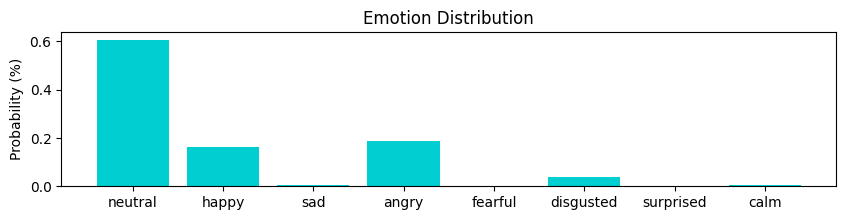

Max emotion: neutral
----------------------------------------------------------------------------------------------------
** session ended


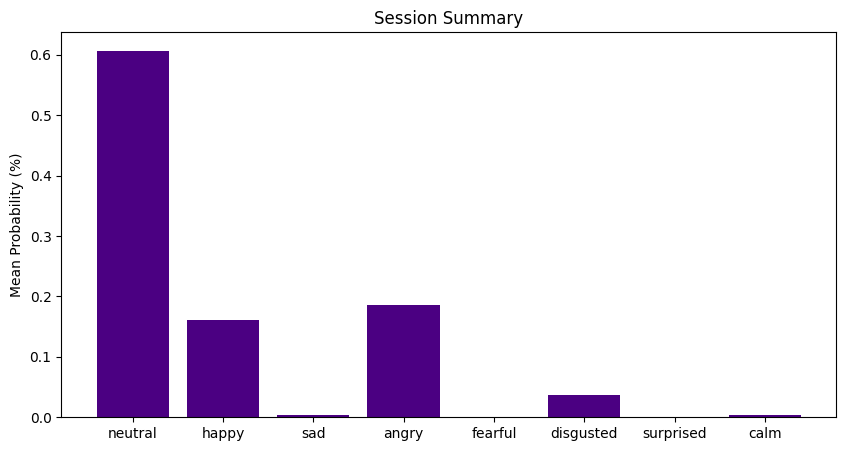

Emotions analyzed for: 2.3826 seconds


In [56]:
import wave
import struct
import time
import numpy as np
import matplotlib.pyplot as plt

# Ensure necessary variables are defined before use
emotions = {i: emo_list[i] for i in range(len(emo_list))}

# Use uploaded file instead of recording
WAVE_OUTPUT_FILE = "/content/Sad mood.wav.wav"

# SESSION START
print("** session started")
total_predictions = []  # Store all predictions
tic = time.perf_counter()

# Process the uploaded WAV file
x = preprocess(WAVE_OUTPUT_FILE)  # Ensure `preprocess()` handles the file properly

# Ensure `x` has the correct shape for model input
if x is None or not isinstance(x, np.ndarray) or len(x.shape) != 3:
    raise ValueError("Preprocessed data is not in the correct shape (batch, timesteps, features).")

# Model's prediction => an 8-emotion probability array
predictions = model.predict(x)
pred_np = np.squeeze(np.array(predictions), axis=0)
total_predictions.append(pred_np)

# Present emotion distribution
plt.figure(figsize=(10, 2))
plt.bar(emo_list, pred_np, color='darkturquoise')
plt.ylabel("Probability (%)")
plt.title("Emotion Distribution")
plt.show()

max_emo = np.argmax(pred_np)
print('Max emotion:', emotions.get(max_emo, "Unknown"))

print(100 * '-')

# SESSION END
toc = time.perf_counter()
print('** session ended')

# Present overall session summary
total_predictions_np = np.mean(np.array(total_predictions), axis=0)
plt.figure(figsize=(10, 5))
plt.bar(emo_list, total_predictions_np, color='indigo')
plt.ylabel("Mean Probability (%)")
plt.title("Session Summary")
plt.show()

print(f"Emotions analyzed for: {(toc - tic):0.4f} seconds")
